# Cải tiến mô hình với biến mới Odds

In [1]:
import os
import random
import datetime
import time
import math
import subprocess
from glob import glob
import operator
import numpy as np
import pandas as pd
from collections import Counter

import scipy.stats as ss
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
import keras

from tensorflow.keras.layers import Dense, Input, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.metrics import Metric
import tensorflow.keras.optimizers as Optimizer
import tensorflow_addons as tfa 

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os.path as path
lib_path =  path.abspath(path.join('' ,"../../api/common"))
sys.path.insert(1, lib_path)
from transform_split_data import transform_split_data
from predict import predict, evaluate

%load_ext autoreload
%autoreload 2
%load_ext autotime
%load_ext tensorboard
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

time: 0 ns


- Khởi tạo phương thức giải phóng bộ nhớ gpu

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
time: 750 ms


## 1. Load data
- Load dữ liệu đã thêm biến mới ...ip2.csv

In [3]:
# Load dữ liệu
train_data = pd.read_csv('train_data_ip2.csv')
train_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,before_Odds,speed
0,4739,2006102819,2009,-0.560469,0.0,1.0,0.0,1.0,-0.381357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709237,59.433962
1,27702,2013104745,2016,-1.045283,0.0,1.0,0.0,1.0,-0.965836,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652,56.767411
2,10633,2007101765,2011,0.409159,0.0,1.0,0.0,1.0,0.495360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.524838,56.470588
3,8902,2008100059,2010,-0.075655,1.0,0.0,1.0,0.0,-0.089118,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652,58.655804
4,28225,2012104831,2016,-1.045283,1.0,0.0,1.0,0.0,0.495360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.654645,63.576159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,31174,2012100286,2017,0.409159,0.0,1.0,0.0,0.0,0.495360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058988,55.574614
475192,23938,2007104998,2014,0.409159,0.0,1.0,0.0,0.0,1.079838,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570637,56.792287
475193,32138,2011101513,2017,1.378788,1.0,0.0,1.0,0.0,0.787599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.597627,59.459459
475194,32286,2012102017,2017,-1.530097,1.0,0.0,0.0,0.0,1.372077,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.567298,63.492063


time: 8.55 s


In [4]:
# Load dữ liệu
test_data = pd.read_csv('test_data_ip2.csv')
test_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,before_Odds,speed
0,34535,2015101022,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.638874,58.064516
1,34535,2015103483,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.068149,57.908847
2,34535,2015106010,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.547888,59.178082
3,34535,2015102342,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188494,58.775510
4,34535,2015102323,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.456902,57.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,35925,2014105425,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.671629,58.378378
19141,35925,2014105543,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.698319,57.857143
19142,35925,2011106130,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.291248,57.754011
19143,35925,2012102418,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.701958,57.497782


time: 407 ms


In [5]:
y_train_df = pd.read_csv('y_train_df_ip2.csv')
y_train_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2009,4739,2006102819,59.433962,84.80,7,0
1,2016,27702,2013104745,56.767411,76.10,12,0
2,2011,10633,2007101765,56.470588,114.75,1,1
3,2010,8902,2008100059,58.655804,98.20,11,0
4,2016,28225,2012104831,63.576159,67.95,3,1
...,...,...,...,...,...,...,...
475191,2017,31174,2012100286,55.574614,116.60,12,0
475192,2014,23938,2007104998,56.792287,114.10,13,0
475193,2017,32138,2011101513,59.459459,133.20,4,0
475194,2017,32286,2012102017,63.492063,56.70,3,1


time: 281 ms


In [6]:
y_test_df = pd.read_csv('y_test_df_ip2.csv')
y_test_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2018,34535,2015101022,58.064516,74.4,10,0
1,2018,34535,2015103483,57.908847,74.6,11,0
2,2018,34535,2015106010,59.178082,73.0,2,1
3,2018,34535,2015102342,58.775510,73.5,6,0
4,2018,34535,2015102323,57.142857,75.6,16,0
...,...,...,...,...,...,...,...
19140,2018,35925,2014105425,58.378378,111.0,1,1
19141,2018,35925,2014105543,57.857143,112.0,5,0
19142,2018,35925,2011106130,57.754011,112.2,6,0
19143,2018,35925,2012102418,57.497782,112.7,8,0


time: 32 ms


- Create X, y data

In [7]:
drop_columns = ['race_id', 'KettoNum', 'id$Year', 'speed'] 
X_train = train_data.drop(drop_columns, axis=1)
X_train

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,before_Odds
0,-0.560469,0.0,1.0,0.0,1.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709237
1,-1.045283,0.0,1.0,0.0,1.0,-0.965836,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652
2,0.409159,0.0,1.0,0.0,1.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.524838
3,-0.075655,1.0,0.0,1.0,0.0,-0.089118,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652
4,-1.045283,1.0,0.0,1.0,0.0,0.495360,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.654645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,0.409159,0.0,1.0,0.0,0.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058988
475192,0.409159,0.0,1.0,0.0,0.0,1.079838,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570637
475193,1.378788,1.0,0.0,1.0,0.0,0.787599,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.597627
475194,-1.530097,1.0,0.0,0.0,0.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.567298


time: 313 ms


In [8]:
y_train = train_data['speed']
y_train.describe()

count    475196.000000
mean         58.393319
std           2.308153
min          21.973550
25%          56.942004
50%          58.536585
75%          59.916782
max          66.666667
Name: speed, dtype: float64

time: 31 ms


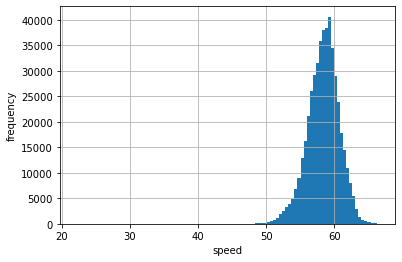

time: 344 ms


In [9]:
y_train.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

In [10]:
X_test = test_data.drop(drop_columns, axis=1)
X_test

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,before_Odds
0,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.638874
1,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.068149
2,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.547888
3,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188494
4,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.456902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.671629
19141,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.698319
19142,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.291248
19143,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.701958


time: 46 ms


In [11]:
y_test = test_data['speed']
y_test.describe()

count    19145.000000
mean        58.013408
std          2.305421
min         38.876890
25%         56.509695
50%         58.142665
75%         59.558824
max         65.573770
Name: speed, dtype: float64

time: 0 ns


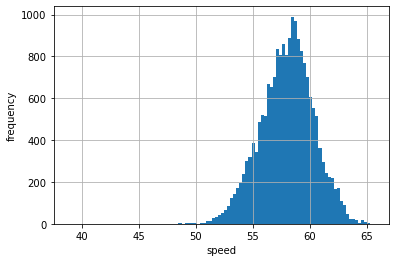

time: 297 ms


In [12]:
y_test.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

## 2. Train with ANN

- Create and compile Model

In [13]:
from tensorflow.keras import backend as K

def my_r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()) )

def BatchNorm():
    return BatchNormalization(
                momentum=0.95, 
                epsilon=0.005,
                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                gamma_initializer=Constant(value=0.9)
                )

#model.add(BatchNorm())
#model.add(Dropout(0.07))
#model.add(Dense(units=num_2, activation='relu'))
#model.add(BatchNorm())     

def build_and_compile_model(X_train, num_units=100, activation='sigmoid'):
    input_shape = X_train.shape[1] 
    model = Sequential()
    model.add(Dense(units=num_units, activation=activation, kernel_initializer='he_normal',
                    input_shape=(input_shape,)))
    model.add(Dense(1))
      
    model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), my_r2_score], optimizer=Optimizer.Adam(0.01)) #my_r2_score
    
    return model


time: 0 ns


- Setup callback

In [14]:
class My_checkoint(Callback):
        
    def __init__(self, model, X_test, y_test, checkpoint_name):
        self.X_test = X_test
        self.y_test = y_test
        self.mode = model
    def on_epoch_end(self, epoch, logs=None):
        cpn = checkpoint_name + format(epoch, '02d') + '-.hdf5'
        #cpn = os.path.join(checkpoint_dir, 'model'+format(epoch, '02d') + '-.hdf5')
        val_loss = self.mode.evaluate(self.X_test, self.y_test)
        print('my_val_loss', val_loss)
        self.mode.save(cpn)
        
def callback_model(model, checkpoint_name, logdir, X_test, y_test):
  
    _logdir = os.path.join(logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(_logdir, histogram_freq=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.3,
                                  patience=1,
                                  mode='min',
                                  verbose=1)
    
    early_stopping = EarlyStopping(patience=7,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)
    
    csv_logger = CSVLogger('log.log', separator=',', append=False)
    
    callbacks_list = [tensorboard_callback, reduce_lr, early_stopping, csv_logger, My_checkoint(model, X_test, y_test, checkpoint_name)]
    
    return callbacks_list


time: 0 ns


- Create train model

In [15]:
def train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir, batch_size=32, epochs=10, re_train=True):

    if re_train:
        # Clear old folder
        %rmdir /q/s {logdir}
        # Clear old file
        path = checkpoint_name + '**'
        all_path_files = glob(path)
        for file in all_path_files:
            os.remove(file)
        # fit model
        callbacks_list = callback_model(model, checkpoint_name, logdir, X_test, y_test)
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callbacks_list)
        
        #del model
        
    # Get best file by reading log file
    df = pd.read_csv('log.log')
    best_epoch = df.loc[df['val_loss']==df['val_loss'].min(), 'epoch'].values[0]
    best_file = 'model-' + format(best_epoch, '02d') + '-.hdf5'
    #best_file = os.path.join(checkpoint_dir, 'model'+format(best_epoch, '02d') + '-.hdf5')
    model = load_model(best_file, custom_objects={'my_r2_score': my_r2_score})
    return model


time: 0 ns


- <span style="color:blue">Train với bộ thông số tốt nhất trước khi cải tiến:
    - units: 275
    - batch_size: 128
    - activation: sigmoid
   

In [16]:
checkpoint_name = 'model-'
baseDir = os.path.abspath(os.getcwd())
logs_name = 'training_logs'
logdir = os.path.join(baseDir, logs_name)
#checkpoint_dir = os.path.join(baseDir, checkpoint_name)
model = build_and_compile_model(X_train, num_units=275, activation='sigmoid')

model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                    batch_size=128, epochs=15, re_train=True)


Epoch 1/15
   1/3713 [..............................] - ETA: 0s - loss: 3346.1116 - root_mean_squared_error: 57.8456 - my_r2_score: -734.3478WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
150/150 [==============================] - 0s 2ms/step - loss: 0.7829 - root_mean_squared_error: 0.8848 - my_r2_score: 0.7966
my_val_loss [0.7829405069351196, 0.8848392367362976, 0.7965864539146423]
3713/3713 [==============================] - 11s 3ms/step - loss: 8.9996 - root_mean_squared_error: 2.9999 - my_r2_score: -0.7819 - val_loss: 0.7829 - val_root_mean_squared_error: 0.8848 - val_my_r2_score: 0.7966
Epoch 2/15
150/150 [==============================] - 0s 2ms/step - loss: 0.7636 - root_mean_squared_error: 0.8738 - my_r2_score: 0.7997
my_val_loss [0.7

- Evaluate model

In [17]:
# On train
train_result_df = evaluate(model, X_train, y_train_df)
#train_result_df

Sai số rmse:                    0.769
Hệ số xác định r2-score: 0.889
Tỉ lệ True positive:           0.411
time: 30.2 s


In [18]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)
#test_result_df

Sai số rmse:                    0.831
Hệ số xác định r2-score: 0.870
Tỉ lệ True positive:           0.392
time: 421 ms


In [19]:
log_data = pd.read_csv('log.log')
log_data['epoch'] = log_data['epoch'] + 1
log_data

,epoch,loss,lr,my_r2_score,root_mean_squared_error,val_loss,val_my_r2_score,val_root_mean_squared_error
0,1,8.999556,1.000000e-02,-0.781868,2.999926,0.782941,0.796586,0.884839
1,2,0.648681,1.000000e-02,0.877689,0.805408,0.763583,0.799714,0.873832
2,3,0.631070,1.000000e-02,0.880874,0.794399,0.702544,0.816056,0.838179
3,4,0.615439,1.000000e-02,0.883901,0.784499,0.776114,0.795811,0.880973
4,5,0.569448,3.000000e-03,0.892781,0.754618,0.779231,0.795737,0.882740
5,6,0.545403,9.000000e-04,0.897338,0.738514,0.689954,0.820547,0.830635
6,7,0.541872,9.000000e-04,0.897980,0.736120,0.723899,0.810851,0.850823
7,8,0.533003,2.700000e-04,0.899689,0.730071,0.730603,0.808922,0.854753
8,9,0.529899,8.100000e-05,0.900277,0.727942,0.748914,0.803742,0.865398
9,10,0.528883,2.430000e-05,0.900450,0.727244,0.742056,0.805533,0.861427


time: 16 ms


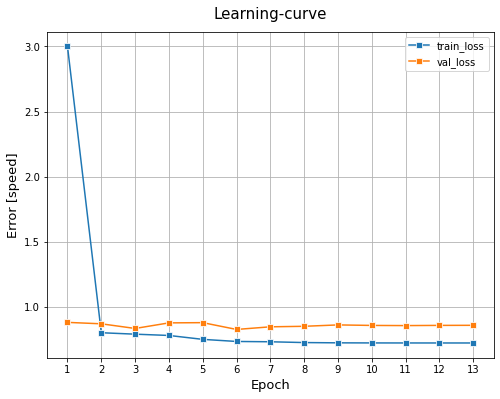

time: 297 ms


In [20]:
def plot_loss(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='root_mean_squared_error', data=log_data, marker='s', label='train_loss');
    sns.lineplot(x='epoch', y='val_root_mean_squared_error', data=log_data, marker='s', label='val_loss');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('Error [speed]', size=13)
    plt.legend()
    plt.title('Learning-curve', size=15, y=1.02)
    plt.grid(True)

plot_loss(log_data)

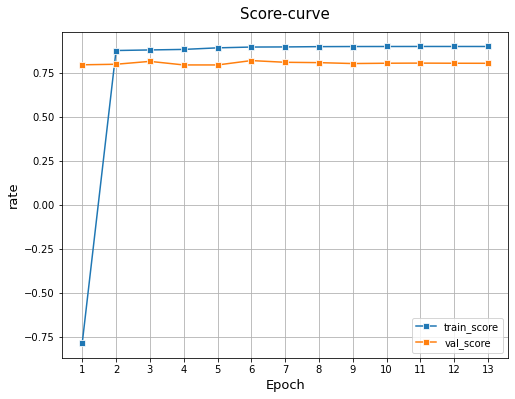

time: 266 ms


In [21]:
def plot_r2(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='my_r2_score', data=log_data, marker='s', label='train_score');
    sns.lineplot(x='epoch', y='val_my_r2_score', data=log_data, marker='s', label='val_score');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('rate', size=13)
    plt.legend()
    plt.title('Score-curve', size=15, y=1.02)
    plt.grid(True)

plot_r2(log_data)